In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

from torchsummary import summary

In [3]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),

    transforms.RandomCrop(32,padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
batch_size = 64

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
class BasicBlock(nn.Module):
    """
    For shallow networks, such as ResNet-18/34, etc., use the basic Block
    The base module is not compressed, so expansion=1
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # If the input and output dimensions are not equal, use a 1x1 convolutional layer to change the dimension
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
    def forward(self, x):
        out = self.features(x)
# print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [8]:
class Bottleneck(nn.Module):
    """
    For deep networks, we use BottleNeck, which is proposed in the paper to have approximate computational complexity but save a lot of resources
    zip_channels: The compressed dimension, the final output dimension is expansion * zip_channels
    For the network structure of ResNet50/101/152, mainly because the third layer is 4 times the second layer, so expansion=4
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
# print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    """
    Different ResNet architectures are unified with one layer of feature extraction and four layers of residuals, and the difference lies in the depth of each layer of residuals.
    For cifar10, the change of feature map size is as follows:
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2]
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool]
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=10, verbose = False):
        super(ResNet, self).__init__()
        self.verbose = verbose
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        #Use the _make_layer function to generate the structure of conv2_x, conv3_x, conv4_x, conv5_x corresponding to the above table
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # After cifar10 goes through the above structure, the feature map size here is 4 x 4 x 512 x expansion
        # So 4 x 4 average pooling is used here
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 *block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # The first block needs to be downsampled
        strides = [stride] + [1]* (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # If it is Bottleneck Block, you need to compress the input dimension of each layer, and then increase the dimension after compression
            # So the input dimension of each layer should also change accordingly
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        out = self.layer1(out)
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))
        out = self.layer2(out)
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))
        out = self.layer3(out)
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
        out = self.layer4(out)
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [10]:
def ResNet18(verbose=False):
    return ResNet(BasicBlock, [2,2,2,2],verbose=verbose)

def ResNet34(verbose=False):
    return ResNet(BasicBlock, [3,4,6,3],verbose=verbose)

def ResNet50(verbose=False):
    return ResNet(Bottleneck, [3,4,6,3],verbose=verbose)

def ResNet101(verbose=False):
    return ResNet(Bottleneck, [3,4,23,3],verbose=verbose)

def ResNet152(verbose=False):
    return ResNet(Bottleneck, [3,8,36,3],verbose=verbose)

net = ResNet18(True).to(device)

In [11]:
net = ResNet34()
# .to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True


In [12]:
summary(net, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,728
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
├─Sequential: 1-2                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-4                   [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-1              [-1, 64, 32, 32]          73,984
|    |    └─Sequential: 3-2              [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-5                   [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-3              [-1, 64, 32, 32]          73,984
|    |    └─Sequential: 3-4              [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-6                   [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-5              [-1, 64, 32, 32]          73,984

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,728
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
├─Sequential: 1-2                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-4                   [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-1              [-1, 64, 32, 32]          73,984
|    |    └─Sequential: 3-2              [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-5                   [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-3              [-1, 64, 32, 32]          73,984
|    |    └─Sequential: 3-4              [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-6                   [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-5              [-1, 64, 32, 32]          73,984

In [10]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, verbose=True, patience = 5, min_lr = 0.000001) 

import time
epoch = 50

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [11]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/ResNet34.pth'

The file already exists


In [12]:
def get_acc(outputs, label):
    total = outputs.shape[0]
    probs, pred_y = outputs.data.max(dim=1) 
    correct = (pred_y == label).sum().data
    return correct / total


def train(net, trainloader, testloader, epoches, optimizer , criterion, scheduler , path = './model.pth', writer = None ,verbose = False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list  = []
    for i in range(epoches):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            outputs = net(im)
            loss = criterion(outputs,label)
            # backward
            loss.backward()
            optimizer.step()

            train_loss += loss.data
            train_acc += get_acc(outputs,label)
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        if verbose:
            train_acc_list.append(train_acc.item())
            train_loss_list.append(train_loss.item())
    #     print('train_loss:{:.6f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
        lr = optimizer.param_groups[0]['lr']
        if verbose:
            lr_list.append(lr)
        scheduler.step(train_loss)
        if testloader is not None:
            net.eval()
            with torch.no_grad():
                for step,data in enumerate(testloader,start=0):
                    im,label = data
                    im = im.to(device)
                    label = label.to(device)
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                    outputs = net(im)
                    loss = criterion(outputs,label)
                    test_loss += loss.data
                    test_acc += get_acc(outputs,label)
                    rate = (step + 1) / len(testloader)
                    a = "*" * int(rate * 50)
                    b = "." * (50 - int(rate * 50))
                    print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
            test_loss = test_loss / len(testloader)
            test_acc = test_acc * 100 / len(testloader)
            if verbose:
                test_loss_list.append(test_loss.item())
                test_acc_list.append(test_acc.item())
            end = time.time()
            print(
                '\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoches, train_loss, train_acc, test_loss, test_acc,lr), end='')
        else:
            end = time.time()
            print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(i+1,epoches,train_loss,train_acc,lr),end = '')
        time_ = int(end - start)
        h = time_ / 3600
        m = time_ % 3600 /60
        s = time_ % 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        if writer is not None:
            writer.add_scalars('Loss', {'train': train_loss,
                                    'valid': test_loss}, i+1)
            writer.add_scalars('Acc', {'train': train_acc ,
                                   'valid': test_acc}, i+1)
            writer.add_scalars('Learning Rate',lr,i+1)
        # =========================================================
        print(time_str)
        if test_acc > best_acc:
            torch.save(net,path)
            best_acc = test_acc
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list
    return Acc, Loss, Lr


In [13]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/ 50]  Train Loss:1.594708  Train Acc:41.73% Test Loss:1.506955  Test Acc:49.46%  Learning Rate:0.010000	Time 02:14
Epoch [  2/ 50]  Train Loss:1.059836  Train Acc:62.09% Test Loss:0.916111  Test Acc:67.87%  Learning Rate:0.010000	Time 02:12
Epoch [  3/ 50]  Train Loss:0.800509  Train Acc:71.91% Test Loss:0.836818  Test Acc:72.08%  Learning Rate:0.010000	Time 02:12
Epoch [  4/ 50]  Train Loss:0.676339  Train Acc:76.68% Test Loss:0.657622  Test Acc:77.34%  Learning Rate:0.010000	Time 02:15
Epoch [  5/ 50]  Train Loss:0.569974  Train Acc:80.39% Test Loss:0.575478  Test Acc:80.67%  Learning Rate:0.010000	Time 02:12
Epoch [  6/ 50]  Train Loss:0.507744  Train Acc:82.51% Test Loss:0.594695  Test Acc:80.20%  Learning Rate:0.010000	Time 02:11
Epoch [  7/ 50]  Train Loss:0.461540  Train Acc:84.35% Test Loss:0.493319  Test Acc:83.48%  Learning Rate:0.010000	Time 02:11
Epoch [  8/ 50]  Train Loss:0.414028  Train Acc:85.81% Test Loss:0.492149  Test Acc:84.15%  Learning Rate:0.010000	Tim

In [14]:
import matplotlib.pyplot as plt


def plot_history(epoches, Acc, Loss, lr):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()
    

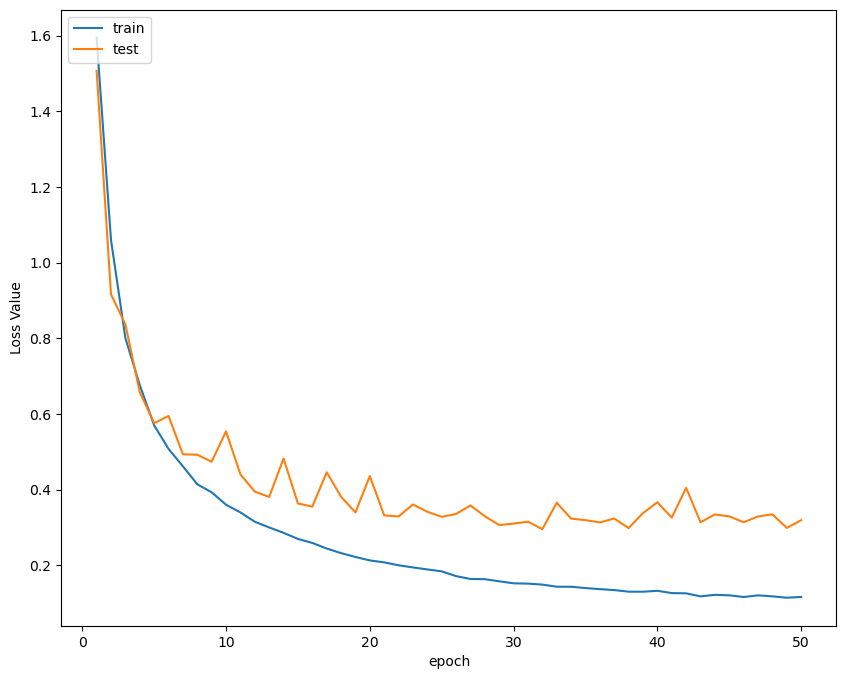

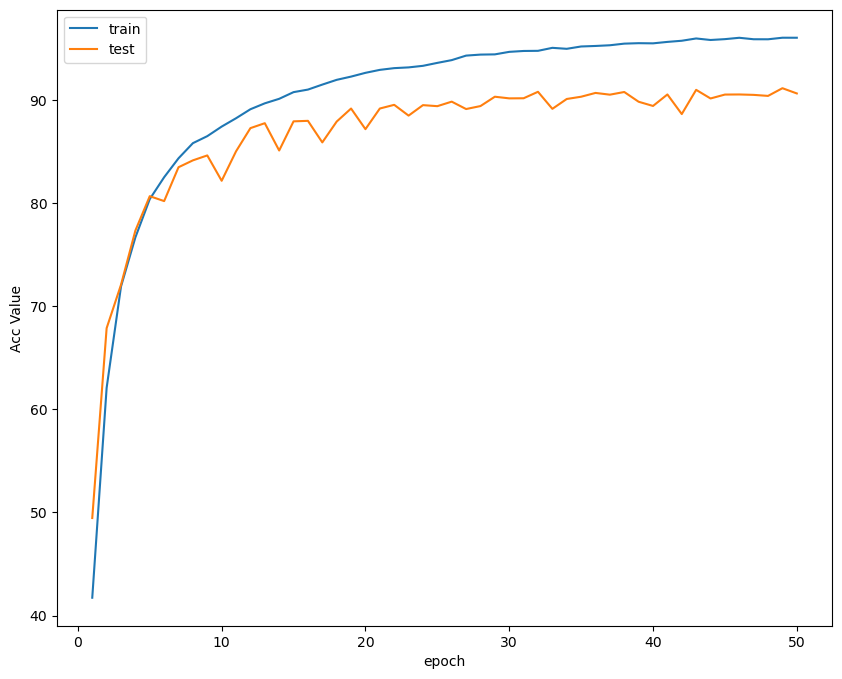

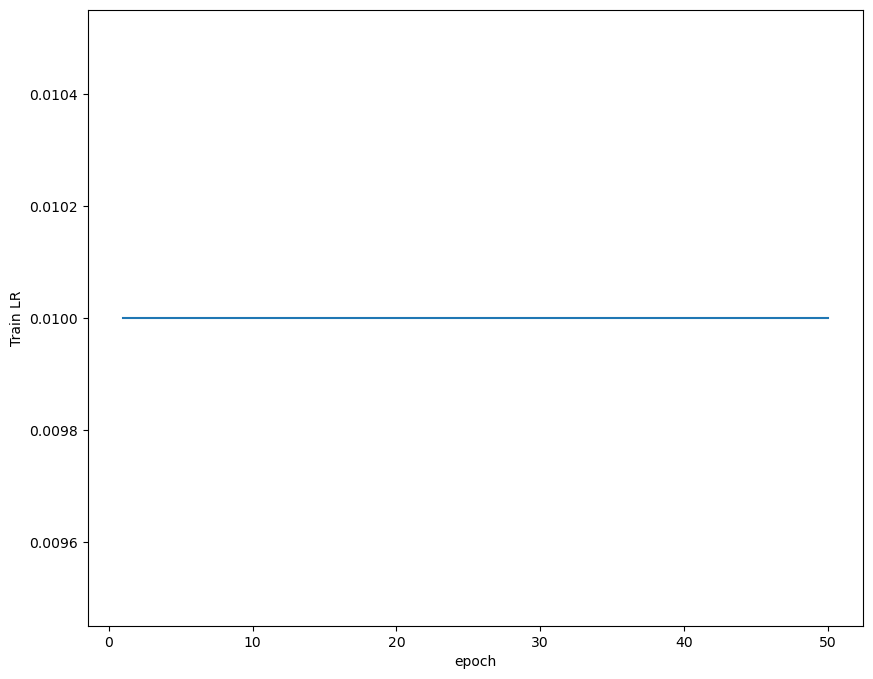

In [15]:
plot_history(epoch ,Acc, Loss, Lr)

In [16]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 90.65 %


In [17]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 95.00 %
Accuracy of   car : 94.60 %
Accuracy of  bird : 92.50 %
Accuracy of   cat : 80.90 %
Accuracy of  deer : 90.50 %
Accuracy of   dog : 85.40 %
Accuracy of  frog : 93.40 %
Accuracy of horse : 90.50 %
Accuracy of  ship : 87.50 %
Accuracy of truck : 96.20 %


In [18]:
def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                num = conf_mat[i, j].astype(np.int64) 
                cell_text += format(num, 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

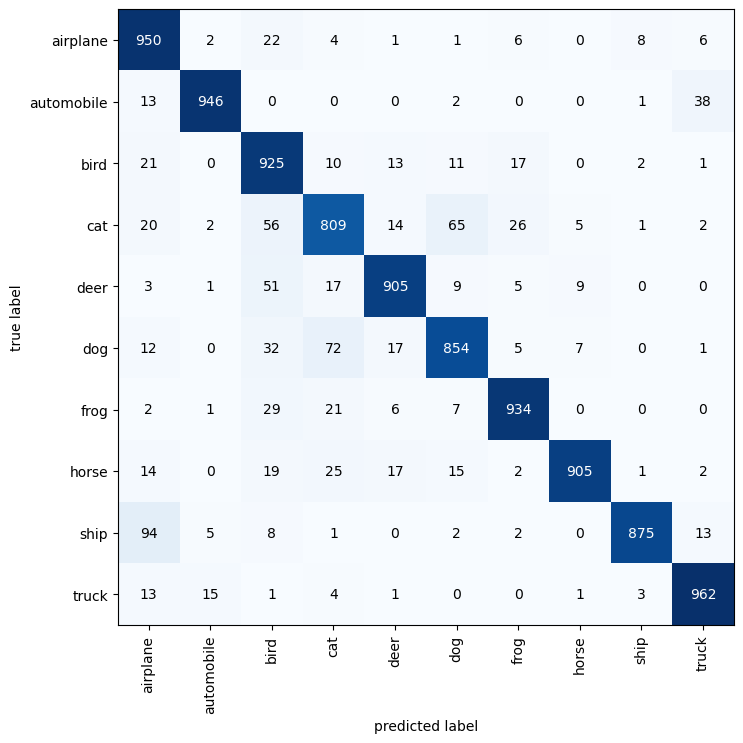

In [19]:
import numpy as np
from itertools import product

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()